In [1]:
from __future__ import division, print_function
import numpy as np
from scipy import interpolate
import pyfits
import plotc
import read_params
import matplotlib.pyplot as plt
from scipy.special import j1,j0,jn
def j2(z): return jn(2,z)
def j1prime(z): return 0.5*(j0(z)-j2(z))
import os,shutil
%matplotlib inline

z surf -0.01 Mm
vz at surface 4.83 m/s
vx at surface 0.32 m/s
vx peak depth -1.59 Mm
vz peak depth -2.34 Mm


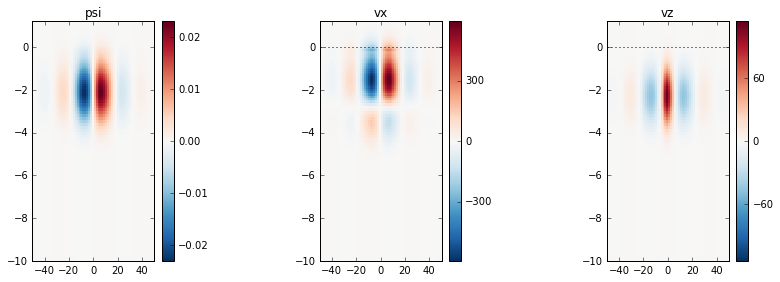

In [2]:
Lx = read_params.get_xlength()
nx = read_params.get_nx()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
Rsun=695.8
z,c_sound = np.loadtxt(read_params.get_solarmodel(),usecols=[0,1],unpack=True); z=(z-1)*Rsun;c_sound/=100;

psi_true = np.squeeze(pyfits.getdata(read_params.get_true_psi_filename()))
vx_true = np.squeeze(pyfits.getdata(read_params.get_true_vx_filename()))
vz_true = np.squeeze(pyfits.getdata(read_params.get_true_vz_filename()))
nz_max,nx_max = np.unravel_index(psi_true.argmax(),psi_true.shape)

z_surf_ind = abs(z).argmin()
vz_surf = vz_true[z_surf_ind,nx//2]
vx_surf = vz_true[z_surf_ind,nx_max]
print("z surf {:.2f}".format(z[z_surf_ind]),"Mm")
print("vz at surface {:.2f} m/s".format(vz_surf))
print("vx at surface {:.2f} m/s".format(vx_surf))
print("vx peak depth {:.2f} Mm".format(z[vx_true[:,nx_max].argmax()]))
print("vz peak depth {:.2f} Mm".format(z[vz_true[:,nx//2].argmax()]))

gl = plotc.gridlist(1,3)
plotc.colorplot(psi_true,x=x,y=z,yr=[-10,None],xr=[-50,50],sp=next(gl),centerzero=True);
plt.title("psi")
plotc.colorplot(vx_true,x=x,y=z,yr=[-10,None],xr=[-50,50],sp=next(gl),centerzero=True);
plt.title("vx")
plt.axhline(z[z_surf_ind],color='black',ls='dotted')
plotc.colorplot(vz_true,x=x,y=z,yr=[-10,None],xr=[-50,50],sp=next(gl),centerzero=True);
plt.title("vz")
plt.axhline(z[z_surf_ind],color='black',ls='dotted')
plt.tight_layout()

plt.gcf().set_size_inches(12,4);

### Duvall-Hanasoge model

In [3]:
kDH13 = 2*np.pi/30
RDH13 = 15
sigmazDH13 = 0.912
z0DH13 = -2.3
v0DH13 = 240

In [4]:
z_cutoff = -8 # Spline lower cutoff
zspline_ind = z>z_cutoff
zspline = z[z>z_cutoff]

psi_spline = psi_true[z>z_cutoff,nx_max]

## Spline only along z

In [27]:
def coeff_to_model(tck_z):
    f0_x = np.sign(x)*j1(kDH13*abs(x))*np.exp(-abs(x)/RDH13)
    f0_x_max = f0_x.max()
    f0_x/=f0_x_max

    h_z=interpolate.splev(z,tck_z,ext=1)

    return f0_x[None,:]*h_z[:,None]

Knots [-7.881 -7.881 -7.881 -5.548 -3.629 -2.819 -2.11  -0.984  1.188  1.188
  1.188]
Number of knots: 11
Number of coeffs: 8


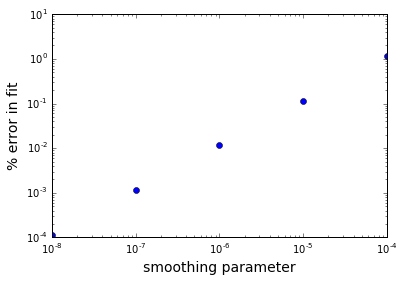

In [28]:
s_misfit = []
s_list = [1e-4,1e-5,1e-6,1e-7,1e-8]
Nparams = []
for s in s_list:
    tz1D,cz1D,kz=interpolate.splrep(zspline.flatten(),psi_spline.flatten(),k=2,s=s)
    misfit = np.sum((psi_true - coeff_to_model((tz1D,cz1D,kz)))**2)/np.sum(psi_true**2)
    s_misfit.append(misfit*100)
    Nparams.append(tz1D.size-kz-1)
    
plt.loglog(s_list,s_misfit,'o')
plt.ylabel("% error in fit",fontsize=14)
plt.xlabel("smoothing parameter",fontsize=14)

tz1D,cz1D,kz=interpolate.splrep(zspline.flatten(),psi_spline.flatten(),k=2,s=1e-4)
np.set_printoptions(precision=3)
print("Knots",tz1D)
print("Number of knots:",tz1D.size)
print("Number of coeffs:",tz1D.size-kz-1)

## Plot of basis splines

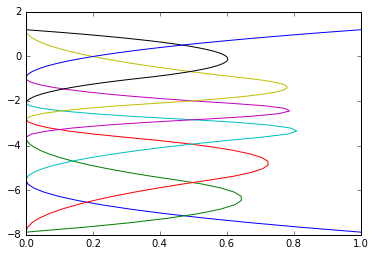

In [29]:
for i in xrange(tz1D.size):
    c_i = np.zeros_like(cz1D)
    c_i[i] = 1
    b_i = interpolate.splev(zspline,(tz1D,c_i,kz))
    plt.plot(b_i,zspline)

### Determine the coefficient that corresponds to the surface

In [33]:
b_i_surf = np.zeros_like(cz1D)
deep_z_cutoff = -6
b_i_deep = np.zeros_like(cz1D)

for i in xrange(tz1D.size):
    c_i = np.zeros_like(cz1D)
    c_i[i] = 1
    b_i_surf[i] = interpolate.splev(0,(tz1D,c_i,kz))
    b_i_deep[i] = interpolate.splev(deep_z_cutoff,(tz1D,c_i,kz))

c_surf_cutoff = b_i_surf.argmax()
print("c surf cutoff index",c_surf_cutoff)
cz1D_top = np.zeros_like(cz1D)
cz1D_top[c_surf_cutoff:] = cz1D[c_surf_cutoff:]
cz1D_bottom = np.zeros_like(cz1D)
cz1D_bottom[:c_surf_cutoff] = cz1D[:c_surf_cutoff]
print("{:d} parameters to  be fit along z, {:d} parameters clamped, "
      .format(c_surf_cutoff,tz1D.size - c_surf_cutoff))
print("Coeffs below surface",cz1D[:c_surf_cutoff])

deep_z_cutoff_ind = b_i_deep.argmax()
print("Deep z cutoff ind",deep_z_cutoff_ind)

c surf cutoff index 6
6 parameters to  be fit along z, 5 parameters clamped, 
Coeffs below surface [ 0.     0.    -0.002  0.013  0.02   0.02 ]
Deep z cutoff ind 1


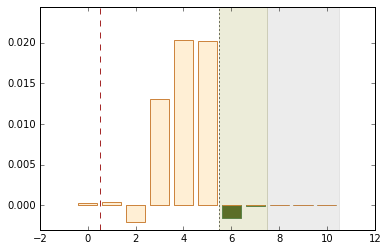

In [34]:
plt.bar(np.arange(cz1D_bottom.size)-0.4,cz1D_bottom,width=0.8,facecolor='papayawhip',edgecolor='peru',zorder=1);
plt.bar(np.arange(cz1D_top.size)-0.4,cz1D_top,width=0.8,facecolor='darkolivegreen',edgecolor='darksage',zorder=0);
plt.axvline(c_surf_cutoff-0.5,color="black",ls="dotted");
plt.axvline(deep_z_cutoff_ind-0.5,color="brown",ls="dashed");
plt.axvspan(c_surf_cutoff-0.5,cz1D_bottom.size-0.5-(kz+1),color="olive",alpha=0.15)
plt.axvspan(cz1D_bottom.size-0.5-(kz+1),cz1D_bottom.size-0.5,color="grey",alpha=0.15)
plt.ylim(cz1D_bottom.min()-0.001,cz1D_bottom.max()*1.2);

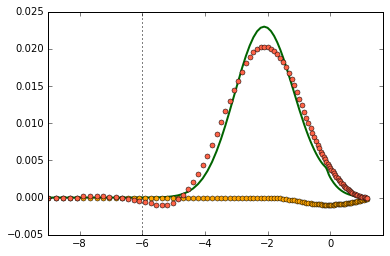

In [41]:
cz1D_top = np.zeros_like(cz1D)
cz1D_top[c_surf_cutoff:] = cz1D[c_surf_cutoff:]
cz1D_bottom = np.zeros_like(cz1D)
cz1D_bottom[:c_surf_cutoff] = cz1D[:c_surf_cutoff]

psi_spl_fit_top=interpolate.splev(z,(tz1D,cz1D_top,kz),ext=1);

plt.plot(z,psi_true[:,nx_max],linewidth=2,color="darkgreen");
plt.plot(z,psi_spl_fit_top,'o',markersize=5,color="orange");

cz1D_bottom = np.zeros_like(cz1D)
cz1D_bottom[:c_surf_cutoff] = cz1D[:c_surf_cutoff]
psi_spl_fit_bottom=interpolate.splev(z,(tz1D,cz1D_bottom,kz),ext=1);
plt.plot(z,psi_spl_fit_bottom,'o',markersize=5,color="tomato");

plt.xlim(-9,z[-1]+0.5);

plt.axvline(deep_z_cutoff,color="black",ls="dotted");

### True and starting model

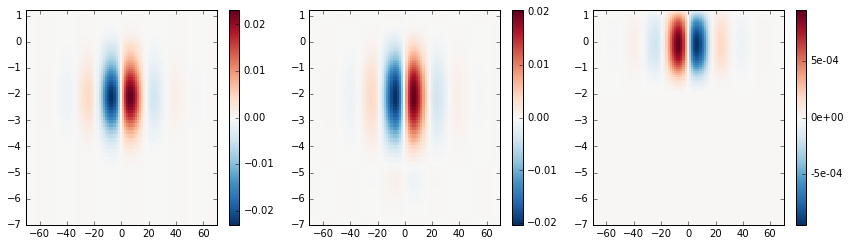

In [36]:
psi_spline = coeff_to_model((tz1D,cz1D_top+cz1D_bottom,kz))
psi_spline_surf = coeff_to_model((tz1D,cz1D_top,kz))
plotc.colorplot(psi_true,x=x,y=z,xr=[-70,70],yr=[-7,None],centerzero=True,sp=131);
plotc.colorplot(psi_spline,x=x,y=z,xr=[-70,70],yr=[-7,None],centerzero=True,sp=132);
plotc.colorplot(psi_spline_surf,x=x,y=z,xr=[-70,70],yr=[-7,None],centerzero=True,sp=133);
plt.gcf().set_size_inches(12,3.5)
plt.tight_layout()

In [40]:
import read_params
import warnings
datadir = read_params.get_directory()
model_back = psi_true.max()/1.04

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pyfits.writeto(os.path.join(datadir,"model_psi_ls00.fits"),
                   psi_spline_surf[:,np.newaxis,:]+model_back,clobber=True)
    shutil.copyfile(os.path.join(datadir,"model_psi_ls00.fits"),
                   os.path.join(datadir,"model_psi_ls00_start.fits"))
    np.savez(os.path.join(datadir,"model_psi_ls00_coeffs.npz"),back=model_back,z=np.zeros_like(cz1D))
    shutil.copyfile(os.path.join(datadir,"model_psi_ls00_coeffs.npz"),
                   os.path.join(datadir,"model_psi_ls00_coeffs_start.npz"))
    np.savez(os.path.join(datadir,"true_psi_coeffs.npz"),tz=tz1D,kz=kz,
        cz_top=cz1D_top,cz_bot=cz1D_bottom,c_surf_cutoff=c_surf_cutoff,z_cutoff = z_cutoff)

## Load model midway and refine splines

In [18]:
datadir = read_params.get_directory()
psi_model = np.squeeze(pyfits.getdata(os.path.join(datadir,"model_psi_ls00.fits")))

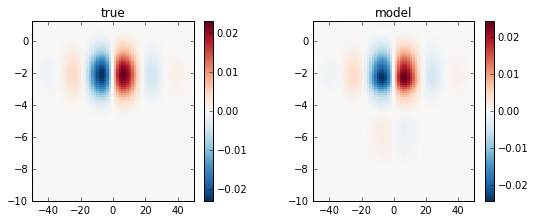

In [12]:
gl = plotc.gridlist(1,2)
plotc.colorplot(psi_true,x=x,y=z,yr=[-10,None],xr=[-50,50],sp=next(gl),centerzero=True);
plt.title("true")

plotc.colorplot(psi_model-psi_model[0,0],x=x,y=z,yr=[-10,None],xr=[-50,50],sp=next(gl),centerzero=True);
plt.title("model")

plt.tight_layout()

plt.gcf().set_size_inches(8,3);

In [64]:
psi_spline = psi_true[z>z_cutoff,nx_max]
tz1D_1e4,cz1D_true_1e4,kz=interpolate.splrep(zspline.flatten(),psi_spline.flatten(),k=2,s=1e-4)
tz1D_1e5,cz1D_true_1e5,kz=interpolate.splrep(zspline.flatten(),psi_spline.flatten(),k=2,s=1e-5)
np.set_printoptions(precision=3)
print("Knots",tz1D_1e5)
print("Number of knots:",tz1D_1e5.size)
print("Number of coeffs:",tz1D_1e5.size-kz-1)

psi_spline = psi_model[z>z_cutoff,nx_max]-psi_model[0,0]
_,cz1D_model_1e4,_ = interpolate.splrep(zspline.flatten(),psi_spline.flatten(),k=2,
                                                 s=1e-4,task=-1,t=tz1D_1e4[3:-3])
_,cz1D_model_1e5,_ = interpolate.splrep(zspline.flatten(),psi_spline.flatten(),k=2,
                                                 s=1e-5,task=-1,t=tz1D_1e5[3:-3])

Knots [-7.881 -7.881 -7.881 -5.548 -4.538 -3.629 -2.819 -2.11  -1.498 -0.984
  1.188  1.188  1.188]
Number of knots: 13
Number of coeffs: 10


In [113]:
b_i_surf_1e5 = np.zeros_like(cz1D_true_1e5)
b_i_surf_1e4 = np.zeros_like(cz1D_true_1e4)
deep_z_cutoff = -6
b_i_deep_1e5 = np.zeros_like(cz1D_true_1e5)
b_i_deep_1e4 = np.zeros_like(cz1D_true_1e4)

for i in xrange(tz1D_1e5.size):
    c_i = np.zeros_like(cz1D_true_1e5)
    c_i[i] = 1
    b_i_surf_1e5[i] = interpolate.splev(0,(tz1D_1e5,c_i,kz))
    b_i_deep_1e5[i] = interpolate.splev(deep_z_cutoff,(tz1D_1e5,c_i,kz))
    
for i in xrange(tz1D_1e4.size):
    c_i = np.zeros_like(cz1D_true_1e4)
    c_i[i] = 1
    b_i_surf_1e4[i] = interpolate.splev(0,(tz1D_1e4,c_i,kz))
    b_i_deep_1e4[i] = interpolate.splev(deep_z_cutoff,(tz1D_1e4,c_i,kz))

c_surf_cutoff_1e5 = b_i_surf_1e5.argmax()
c_surf_cutoff_1e4 = b_i_surf_1e4.argmax()

print("c surf cutoff index",c_surf_cutoff_1e5)
print("{:d} parameters to  be fit along z, {:d} parameters clamped, "
      .format(c_surf_cutoff_1e5,tz1D_1e5.size - c_surf_cutoff_1e5))
print("Coeffs below surface",cz1D[:c_surf_cutoff_1e5])

deep_z_cutoff_ind_1e4 = b_i_deep_1e4.argmax()
print("Deep z cutoff ind",deep_z_cutoff_ind_1e4)

deep_z_cutoff_ind_1e5 = b_i_deep_1e5.argmax()
print("Deep z cutoff ind",deep_z_cutoff_ind_1e5)

c surf cutoff index 8
8 parameters to  be fit along z, 5 parameters clamped, 
Coeffs below surface [-0.     0.    -0.     0.002  0.012  0.022  0.022  0.016]
Deep z cutoff ind 1
Deep z cutoff ind 1


In [66]:
cz1D_model_1e5[c_surf_cutoff_1e5:] = cz1D_true_1e5[c_surf_cutoff_1e5:]
cz1D_top_1e5 = np.zeros_like(cz1D_true_1e5)
cz1D_top_1e5[c_surf_cutoff_1e5:] = cz1D_true_1e5[c_surf_cutoff_1e5:]

cz1D_top_1e4 = np.zeros_like(cz1D_true_1e4)
cz1D_top_1e4[c_surf_cutoff_1e4:] = cz1D_true_1e4[c_surf_cutoff_1e4:]

cz1D_bottom_1e5 = np.zeros_like(cz1D_true_1e5)
cz1D_bottom_1e5[:c_surf_cutoff_1e5] = cz1D_true_1e5[:c_surf_cutoff_1e5]

cz1D_bottom_1e4 = np.zeros_like(cz1D_true_1e4)
cz1D_bottom_1e4[:c_surf_cutoff_1e4] = cz1D_true_1e4[:c_surf_cutoff_1e4]

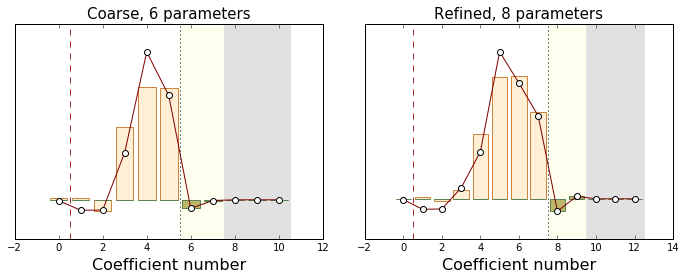

In [123]:
plt.subplot(121)
plt.plot(cz1D_model_1e4,marker='o',color='maroon',markerfacecolor="white",markeredgewidth=1,zorder=2)
plt.bar(np.arange(cz1D_bottom_1e4.size)-0.4,cz1D_bottom_1e4,width=0.8,facecolor='papayawhip',edgecolor='peru',zorder=1);
plt.bar(np.arange(cz1D_top_1e4.size)-0.4,cz1D_top_1e4,width=0.8,facecolor='darkkhaki',edgecolor='darksage',zorder=1);
plt.axvline(c_surf_cutoff_1e4-0.5,color="black",ls="dotted");
plt.axvline(deep_z_cutoff_ind_1e4-0.5,color="brown",ls="dashed");
plt.axvspan(c_surf_cutoff_1e4-0.5,cz1D_bottom_1e4.size-0.5-(kz+1),color="ivory",zorder=0)
plt.axvspan(cz1D_bottom_1e4.size-0.5-(kz+1),cz1D_bottom_1e4.size-0.5,color="#E1E1E1",zorder=0)
plt.ylim(cz1D_bottom_1e4.min()-0.001,cz1D_bottom_1e4.max()*1.2);
plt.ylim(min(cz1D_model_1e4.min(),cz1D_true_1e4.min())-0.005,max(cz1D_model_1e4.max(),cz1D_true_1e4.max())+0.005);
plt.title("Coarse, {} parameters".format(c_surf_cutoff_1e4),fontsize=15);
plt.gca().yaxis.set_ticks([])
plt.xlabel("Coefficient number",fontsize=16)

plt.subplot(122)
plt.plot(cz1D_model_1e5,marker='o',color='maroon',markerfacecolor="white",markeredgewidth=1,zorder=2)
plt.bar(np.arange(cz1D_bottom.size)-0.4,cz1D_bottom,width=0.8,facecolor='papayawhip',edgecolor='peru',zorder=1);
plt.bar(np.arange(cz1D_top.size)-0.4,cz1D_top,width=0.8,facecolor='darkkhaki',edgecolor='darksage',zorder=1);
plt.axvline(c_surf_cutoff-0.5,color="black",ls="dotted");
plt.axvline(deep_z_cutoff_ind-0.5,color="brown",ls="dashed");
plt.axvspan(c_surf_cutoff-0.5,cz1D_bottom.size-0.5-(kz+1),color="ivory",zorder=0)
plt.axvspan(cz1D_bottom.size-0.5-(kz+1),cz1D_bottom.size-0.5,color="#E1E1E1",zorder=0)
plt.ylim(cz1D_bottom.min()-0.001,cz1D_bottom.max()*1.2);
plt.ylim(min(cz1D_model_1e5.min(),cz1D_true_1e5.min())-0.005,max(cz1D_model_1e5.max(),cz1D_true_1e5.max())+0.005);
plt.title("Refined, {} parameters".format(c_surf_cutoff_1e5),fontsize=15);
plt.gca().yaxis.set_ticks([])
plt.xlabel("Coefficient number",fontsize=16)

plt.tight_layout()
plt.gcf().set_size_inches(10,4);

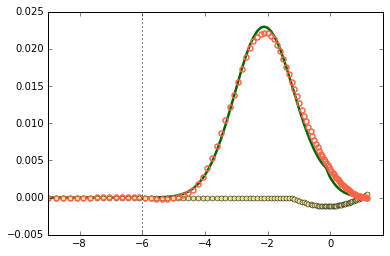

In [128]:
psi_spl_fit_top=interpolate.splev(z,(tz1D,cz1D_top_1e5,kz),ext=1);

plt.plot(z,psi_true[:,nx_max],linewidth=2.5,color="darkgreen");
plt.plot(z,psi_spl_fit_top,'o',markersize=5,color="khaki");

psi_spl_fit_bottom=interpolate.splev(z,(tz1D,cz1D_bottom_1e5,kz),ext=1);
plt.plot(z,psi_spl_fit_bottom,'o',markersize=5,mec="tomato",mfc="None",mew=1.5);

plt.xlim(-9,z[-1]+0.5);

plt.axvline(deep_z_cutoff,color="black",ls="dotted");

In [43]:
import read_params
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    np.savez(os.path.join(datadir,"model_psi_ls00_coeffs.npz"),back=psi_model[0,0],z=cz1D_model_1e5)
    
    shutil.copyfile(os.path.join(datadir,"model_psi_ls00_coeffs.npz"),
                   os.path.join(datadir,"model_psi_ls00_coeffs_start.npz"))
    np.savez(os.path.join(datadir,"true_psi_coeffs.npz"),tz=tz1D_1e5,kz=kz,
        cz_top=cz1D_top_1e5,cz_bot=cz1D_bottom_1e5,c_surf_cutoff=c_surf_cutoff_1e5,z_cutoff = z_cutoff)

## Splines in 2D: 2 independent splines

### Spline fit to horizontal wavelength

In [25]:
wavelength_depths = np.array([-5,-4,-2,-0.5,0]);
tR,cR,kR = interpolate.splrep(wavelength_depths,np.zeros_like(wavelength_depths),k=2)
tR,cR,kR = interpolate.insert(-0.5,(tR,cR,kR),m=2)
print("Number of spline coefficients:",tR.size-2*(kR+1))
print(tR)
print(cR)
R_surf_cutoff = -10

Number of spline coefficients: 7
[-5.  -5.  -5.  -3.  -1.2 -0.5 -0.5  0.   0.   0. ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


### True and starting model

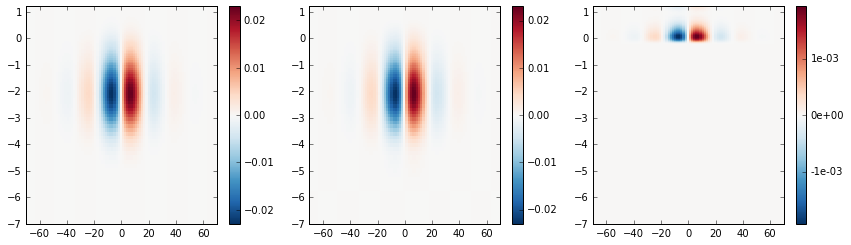

In [38]:
def coeff_to_model(tck_R,tck_z):
    f0_x = np.sign(x)*j1(kDH13*abs(x))*np.exp(-abs(x)/RDH13)
    f0_x_max = f0_x.max()
    # f1_x is the derivative of f0_x wrt R
    f1_x = x*np.exp(-abs(x)/RDH13)/RDH13**2*(j1(kDH13*abs(x))-np.pi*j1prime(kDH13*abs(x)))
    f0_x/=f0_x_max
    f1_x/=f0_x_max

    R1_z = interpolate.splev(z,tck_R,ext=1)
    h_z=interpolate.splev(z,tck_z,ext=1)

    return (f0_x[None,:]+f1_x[None,:]*R1_z[:,None])*h_z[:,None]

psi_spline = coeff_to_model((tR,np.zeros_like(tR),kR),(tz1D,cz1D_top+cz1D_bottom,kz))
psi_spline_surf = coeff_to_model((tR,np.zeros_like(tR),kR),(tz1D,cz1D_top,kz))
plotc.colorplot(psi_true,x=x,y=z,xr=[-70,70],yr=[-7,None],centerzero=True,sp=131);
plotc.colorplot(psi_spline,x=x,y=z,xr=[-70,70],yr=[-7,None],centerzero=True,sp=132);
plotc.colorplot(psi_spline_surf,x=x,y=z,xr=[-70,70],yr=[-7,None],centerzero=True,sp=133);
plt.gcf().set_size_inches(12,3.5)
plt.tight_layout()

### Save Coefficients

In [24]:
import read_params
import warnings
datadir = read_params.get_directory()
print("Saving to",datadir)
model_back = psi_true.max()/1.04
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pyfits.writeto(os.path.join(datadir,"model_psi_ls00.fits"),
                   psi_spline_surf[:,np.newaxis,:]+model_back,clobber=True)
    shutil.copyfile(os.path.join(datadir,"model_psi_ls00.fits"),
                   os.path.join(datadir,"model_psi_ls00_start.fits"))
    np.savez(os.path.join(datadir,"model_psi_ls00_coeffs.npz"),
             back=model_back,z=np.zeros_like(cz1D),R=np.zeros_like(tR))
    shutil.copyfile(os.path.join(datadir,"model_psi_ls00_coeffs.npz"),
                    os.path.join(datadir,"model_psi_ls00_coeffs_start.npz"))
             
    np.savez(os.path.join(datadir,"true_psi_coeffs.npz"),
         cz_top = cz1D_top,cz_bot = cz1D_bottom,tz=tz1D,kz=kz,
         tR = tR,kR=kR,
         z_spline_cutoff=z_cutoff,c_surf_cutoff=c_surf_cutoff,R_surf_cutoff=R_surf_cutoff )

Saving to /scratch/jishnu/flows/spline_f_p3_512
